# M.SMART Хактатон

Хакатон **М.Видео** по обработке естественного языка и использованию искусственного интеллекта для работы с клиентами. 


**Цель:** Предсказание общей оценки товара


**Данные:** Данные: отзывы о товарах с сайта mvideo.ru, оценки, которые поставлены авторами отзыва, категория и брэнд товара. 

[Cкачать данные](http://hackathon.mvideo.ru/files/feedback.csv.rar)

## Анализ датасета

In [2]:
import pandas
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
data = pandas.read_csv("X_train.csv")
data.head(2)

,sku,categoryLevel1Id,categoryLevel2Id,brandId,property,userName,reting,date,comment,commentNegative,commentPositive
0,20005023,401,4010201,826,"[{34: 'f982777489055c6563d68c005fd24aad'}, {36...",b2898a81b45310b30beb8fc0c0a9ce1e,2.0,2013-06-28,"2,5 года работала и все...устала! Лампочка гор...",NaN,NaN
1,20020647,403,4030101,1425,"[{34: '9ce895413ebdf6b6dcb69b07dc782591'}, {36...",538c73d64461e13907bb95c51c38bfbc,2.0,2010-07-04,Через 2 месяца после истечении гарантийного ср...,NaN,NaN


### Описание полей

* **sku** - Уникальный id товара
* **categoryLevel1Id** - id категории товара
* **categoryLevel2Id** - id подкатегории товара
* **brandId** - id бренда товара
* **userName** - id пользователя
* **date** - дата комментария
* **reting** - рейтинг товара, который поставил пользователь
* **comment** - текст комментария
* **commentNegative**/**commentNegative** - позитивная или негативаня оценка в комментарии

### Общая информация о датасете

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15587 entries, 0 to 15586
Data columns (total 11 columns):
sku                 15587 non-null int64
categoryLevel1Id    15587 non-null int64
categoryLevel2Id    15587 non-null int64
brandId             15587 non-null int64
property            15587 non-null object
userName            15587 non-null object
reting              15587 non-null float64
date                15587 non-null object
comment             15587 non-null object
commentNegative     924 non-null object
commentPositive     923 non-null object
dtypes: float64(1), int64(4), object(6)
memory usage: 974.2+ KB


In [20]:
print("Количество пользователей:", len(set(data["userName"].get_values())))
print("Количество товаров:", len(set(data["sku"].get_values())))
print("Количество брендов:", len(set(data["brandId"].get_values())))
comments_count = [data[data["userName"] == uid].shape[0] for uid in set(data["userName"].get_values())]
print("Среднее количество комментариев у одного пользователя:", np.mean(comments_count))
print("Медианное количество комментариев у одного пользователя:", np.median(comments_count))
print("Максимальное количество комментариев у одного пользователя:", np.max(comments_count))

Количество пользователей: 3232
Количество товаров: 2698
Количество брендов: 193
Среднее количество комментариев у одного пользователя: 4.82271039604
Медианное количество комментариев у одного пользователя: 1.0
Максимальное количество комментариев у одного пользователя: 630


Из информации выше можно сделать следущий вывод - брать id о пользователе в качестве дополнительных параметров не рациаонально. Вопервых у нас уже очень много пользователей в комментариях (более 3 тысяч), их количество будет расти на продакшен сервере. Однако это не касается id брендов, поскольку их достаточно ограниченое количество и появляются они не с такой регулярностью, проверим корреляцию средней оценки пользователей с id бренда.

### Распределение оценки по брендам

In [63]:
brands = list(set(data["brandId"].get_values()))
mean_brand_reting = []
median_brand_reting = []

              
for brand in brands:
    brand_reting = data[data["brandId"] == brand]["reting"]
    mean_brand_reting.append(brand_reting.mean())
    median_brand_reting.append(brand_reting.median())

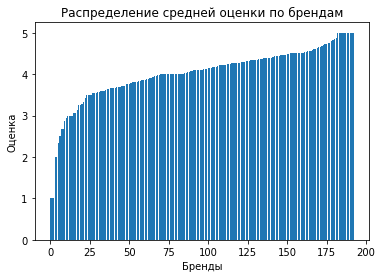

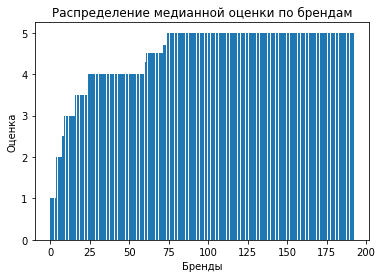

In [73]:
plt.title('Распределение средней оценки по брендам')
plt.xlabel('Бренды')
plt.ylabel('Оценка')
plt.bar(list(range(0,len(mean_brand_reting))), sorted(mean_brand_reting))
plt.show()

plt.title('Распределение медианной оценки по брендам')
plt.xlabel('Бренды')
plt.ylabel('Оценка')
plt.bar(list(range(0,len(median_brand_reting))), sorted(median_brand_reting))
plt.show()

Из графиков выше можно понять, что оценка товара достаточно сильно коррелируется с брендом и может послужить хорошим признаком для улучшения модели. Помимо этого, можно заметить, что медианные значения выглядят достаточно дискретно, что позволяет попробовать решить задачу не только в качестве регрессии, но и в виде классификаци, для этого просмотрим распределение оценок пользователей по количеству.

### Распределение оценок пользователей

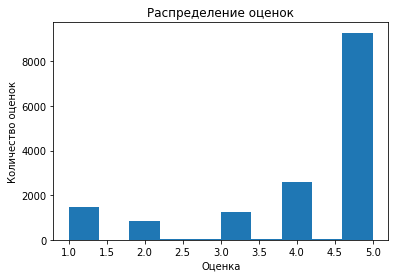

Все виды оценок: {1.0, 2.0, 3.0, 4.0, 5.0, 1.3, 2.3, 3.3, 4.3, 1.7, 2.7, 3.7, 4.7}
Количество видов оценок 13


In [15]:
plt.title('Распределение оценок')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
plt.hist(data["reting"])
plt.show()

print("Все виды оценок:", set(l.get_values().tolist()))
print("Количество видов оценок", len(set(l.get_values().tolist())))

Поскольку количество оценок конечное, 

## Преобразование датасета

### TfIdf

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
ru_stopwords = stopwords.words("russian")

from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

LookupError: 
**********************************************************************
  Resource 'corpora/stopwords' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - 'C:\\Users\\alxmamaev/nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - 'C:\\Program Files\\WinPython\\python-3.5.3\\nltk_data'
    - 'C:\\Program Files\\WinPython\\python-3.5.3\\lib\\nltk_data'
    - 'C:\\Users\\alxmamaev\\AppData\\Roaming\\nltk_data'
**********************************************************************

In [ ]:
class LemaTfidf(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: (morph.parse(word)[0].normal_form for word in analyzer(doc))

tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words=ru_stopwords, max_df=0.6)

In [7]:
vectors = tfidf.fit_transform(data["comment"].get_values())

In [8]:
vectors[0].toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [9]:
vectors.shape[1]

404692

In [10]:
labels = data["reting"].get_values()

In [11]:
x_train, x_test, y_train, y_test = train_test_split(vectors, labels, test_size=0.33, random_state=42)

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(600)
x_train = svd.fit_transform(x_train)

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
lr = LinearRegression()

In [14]:
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
lr.score(x_test, y_test)

0.40668393985760132

In [32]:
comments = data["comment"].get_values()
reting = data["reting"].get_values()

In [13]:
data.shape[0]

15587

In [87]:
i = int(input())

print(comments[i])
print(round (lr.predict(tfidf.transform([comments[i]]))[0], 1))
print(reting[i])

343
Купили машинку, т.к.  мало место в ванной и начитались хороших отзывов на сайте М-Видео. Машинкой не довольна. Помещается очень мало белья, т.к. очень узкий барабан. Если загружать полностью, вообще ничего не отстирывает, даже легкие, не въедающиеся пятна. Приходится класть белья понемногу и стирать по много раз. Большие вещи, такие как одеяло постирать нереально.  Машина прыгает по всей ванной. Собираюсь покупать другую, с большим объемом барабана, правда придется перевешивать дверь в ванной. Если у вас большая семья и много стирки не берите слишком узкие машины.
1.0
1.0


In [88]:
print(round (lr.predict(tfidf.transform([input()]))[0], 1))

Купила сегодня,цена и качество устроили.Дома сразу прошел тест драйв,ни запаха,ни шума.Гладит отлично)))
5.0


In [18]:
np.mean([1,2,3])

2.0